In [1]:
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet
!pip install gym[classic_control]

from pyvirtualdisplay import Display
Display().start()

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  freeglut3 libpython2-stdlib python2 python2-minimal
Suggested packages:
  python-tk python-numpy libgle3 python2-doc
The following NEW packages will be installed:
  freeglut3 libpython2-stdlib python-opengl python2 python2-minimal
0 upgraded, 5 newly installed, 0 to remove and 23 not upgraded.
Need to get 621 kB of archives.
After this operation, 6,059 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 python2-minimal amd64 2.7.17-2ubuntu4 [27.5 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 libpython2-stdlib amd64 2.7.17-2ubuntu4 [7,072 B]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 python2 amd64 2.7.17-2ubuntu4 [26.5 kB]
Get:4 http://archive.ubuntu.com/ubuntu focal/universe amd64 freeglut3 amd64 2.8.1-3 [73.6 kB]
Get:5 http://archive.ubuntu.com/ubuntu f

In [2]:
import gym
from IPython import display
import matplotlib.pyplot as plt
import time
import numpy as np
%matplotlib inline

In [12]:
env = gym.make('MountainCar-v0', new_step_api=True)

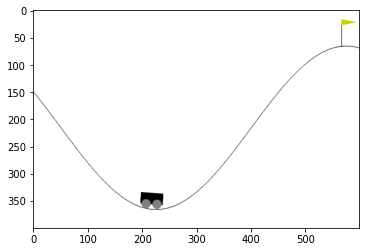

In [15]:
env.reset()
img = plt.imshow(env.render('rgb_array')) # only call this once
for _ in range(100):
  img.set_data(env.render('rgb_array')) # just update the data
  display.display(plt.gcf())
  display.clear_output(wait=True)
  action = env.action_space.sample()
  observation, reward, done, info, _ = env.step(action)
  if done:
    env.reset()
env.close()

In [16]:
def create_bins(num_bins_per_observation):
    car_position = np.linspace(-1.2, 0.6, num_bins_per_observation)  # bins for the car position
    car_velocity = np.linspace(-0.07, 0.07, num_bins_per_observation)  # bins for the car velocity
    bins = np.array([car_position, car_velocity])  # merge them
    return bins

In [17]:
NUM_BINS = 50  #  number of bins for this task
BINS = create_bins(NUM_BINS)  # Create the bins used for the rest of the notebook

In [18]:
def discretize_observation(observations, bins):
    binned_observations = []
    for i, observation in enumerate(observations):
        discretized_observation = np.digitize(observation, bins[i])
        binned_observations.append(discretized_observation)
    return tuple(binned_observations) # Important for later indexing

In [19]:
q_table_shape = (NUM_BINS, NUM_BINS, env.action_space.n)
q_table = np.zeros(q_table_shape)
print(q_table.shape)

(50, 50, 3)


In [20]:
def epsilon_greedy_action_selection(epsilon, q_table, discrete_state):
    if np.random.random() > epsilon:
        action = np.argmax(q_table[discrete_state])
    else:
        action = np.random.randint(0, env.action_space.n)
    return action

In [21]:
def compute_next_q_value(old_q_value, reward, next_optimal_q_value):
    return old_q_value +  ALPHA * (reward + GAMMA * next_optimal_q_value - old_q_value)

In [22]:
def reduce_epsilon(epsilon, epoch):
    if BURN_IN <= epoch <= EPSILON_END:
        epsilon-= EPSILON_REDUCE
    return epsilon

In [23]:
EPOCHS = 30000
BURN_IN = 100
epsilon = 1

EPSILON_END= 10000
EPSILON_REDUCE = 0.0001 #epsilon / EPOCHS

ALPHA = 0.8
GAMMA = 0.9


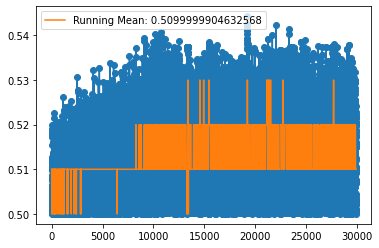

In [24]:
log_interval = 100  # How often do we update the plot? (Just for performance reasons)
### Here we set up the routine for the live plotting of the achieved points ######
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
fig.canvas.draw()
##################################################################################

max_position_log = []  # to store all achieved points
mean_positions_log = []  # to store a running mean of the last 30 results
epochs = []  # store the epoch for plotting

for epoch in range(EPOCHS):
    ################################# TODO ######################################
    
    # TODO: Get initial observation and discretize them. Set done to False
    initial_state = env.reset()  # get the initial observation
    discretized_state = discretize_observation(initial_state, BINS)  # map the observation to the bins
    done = False  # to stop current run when the car reaches the top or the time limit is reached
    
    max_position = -np.inf  # for plotting
    epochs.append(epoch)
    
    # TODO: As long as current run is alive (i.e not done) perform the following steps:
    while not done:  # Perform current run as long as done is False (as long as there is still time to reach the top)


        # TODO: Select action according to epsilon-greedy strategy
        action = epsilon_greedy_action_selection(epsilon, q_table, discretized_state)  # Epsilon-Greedy Action Selection
        
        # TODO: Perform selected action and get next state. Do not forget to discretize it
        next_state, reward, done, info, _ = env.step(action)  # perform action and get next state
        position, velocity = next_state
        next_state_discretized = discretize_observation(next_state, BINS)  # map the next observation to the bins
        
        # TODO: Get old Q-value from Q-Table and get next optimal Q-Value
        old_q_value =  q_table[discretized_state + (action,)]  # get the old Q-Value from the Q-Table
        next_optimal_q_value = np.max(q_table[next_state_discretized])  # Get the next optimal Q-Value
        
        # TODO: Compute next Q-Value and insert it into the table
        next_q = compute_next_q_value(old_q_value, reward, next_optimal_q_value)  # Compute next Q-Value
        q_table[discretized_state + (action,)] = next_q  # Insert next Q-Value into the table
        
        # TODO: Update the old state with the new one
        discretized_state = next_state_discretized  # Update the old state with the new one
        
        if position > max_position:  # Only for plotting the results - store the highest point the car is able to reach
            max_position = position

    # TODO: Reduce epsilon
    epsilon = reduce_epsilon(epsilon, epoch)  # Reduce epsilon
    ##############################################################################

    max_position_log.append(max_position)  # log the highest position the car was able to reach
    running_mean = round(np.mean(max_position_log[-30:]), 2)  # Compute running mean of position over the last 30 epochs
    mean_positions_log.append(running_mean)  # and log it
    
    ################ Plot the points and running mean ##################
    if epoch % log_interval == 0:
        ax.clear()
        ax.scatter(epochs, max_position_log)
        ax.plot(epochs, max_position_log)
        ax.plot(epochs, mean_positions_log, label=f"Running Mean: {running_mean}")
        plt.legend()
        fig.canvas.draw()
  ######################################################################

env.close()


In [ ]:
env.reset()
img = plt.imshow(env.render('rgb_array')) # only call this once
for _ in range(3000):
  img.set_data(env.render('rgb_array')) # just update the data
  display.display(plt.gcf())
  display.clear_output(wait=True)
  discrete_state = discretize_observation(observation, BINS)  # Get discretized observation
  action = np.argmax(q_table[discrete_state])  # and chose action from the Q-Table
  observation, reward, done, info, _ = env.step(action) # Finally perform the action
  if done:
    print(f"done")
    break
env.close()

In [ ]:
np.save('50bin_qtable_mountaincar.npy',q_table)

In [ ]:
our_q_table = np.load('50bin_qtable_mountaincar.npy')

In [ ]:
our_q_table.shape